<a href="https://colab.research.google.com/github/simonavoprea/tiktok/blob/main/BERT_Clustering_tik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap sentence-transformers umap-learn hdbscan sklearn pandas


  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached hdbscan-0.8.40-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install hdbscan

  Using cached hdbscan-0.8.40-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.7 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn


  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Load dataset
file_path = '/content/drive/MyDrive/savedrecs_tiktok.xlsx'  # Update to your file path
df = pd.read_excel(file_path)

# Ensure the "Abstract" column exists
if 'Abstract' not in df.columns:
    raise ValueError("The dataset does not contain an 'Abstract' column.")

# Drop rows with NaN in "Abstract" and reset the index
df = df.dropna(subset=['Abstract']).reset_index(drop=True)

abstracts = df['Abstract'].tolist()

# Step 1: Generate embeddings using BERT
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight BERT model
embeddings = model.encode(abstracts, show_progress_bar=True)

# Step 2: Dimensionality reduction using UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=5, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# Step 3: Clustering using HDBSCAN
cluster_model = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric='euclidean', cluster_selection_epsilon=0.5,  cluster_selection_method='eom')
clusters = cluster_model.fit_predict(reduced_embeddings)

# Add cluster labels to the dataset
df['Cluster'] = clusters

# Step 4: Extract keywords for each cluster
def extract_keywords(texts, cluster_labels, cluster_id):
    cluster_texts = [texts[i] for i in range(len(texts)) if cluster_labels[i] == cluster_id]
    vectorizer = CountVectorizer(stop_words='english', max_features=20)
    bow_matrix = vectorizer.fit_transform(cluster_texts)
    word_counts = bow_matrix.sum(axis=0).A1
    keywords = [vectorizer.get_feature_names_out()[i] for i in word_counts.argsort()[::-1]]
    return keywords

# Generate keywords for each cluster
topics = {}
for cluster_id in set(clusters):
    if cluster_id == -1:  # Skip noise points
        continue
    keywords = extract_keywords(abstracts, clusters, cluster_id)
    topics[cluster_id] = keywords

# Step 5: Display topics
for cluster_id, keywords in topics.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster 0: tiktok, social, videos, media, content, study, health, information, use, video, quality, related, platforms, users, results, using, research, analysis, used, short
Cluster 1: tiktok, china, digital, platform, platforms, media, social, chinese, short, content, douyin, data, article, study, videos, global, international, video, paper, new
Cluster 2: tiktok, learning, social, students, language, media, teaching, study, videos, teachers, educational, use, education, online, english, results, research, using, video, content
Cluster 3: tiktok, social, media, content, videos, video, users, platforms, platform, analysis, study, digital, research, use, political, article, new, user, online, based


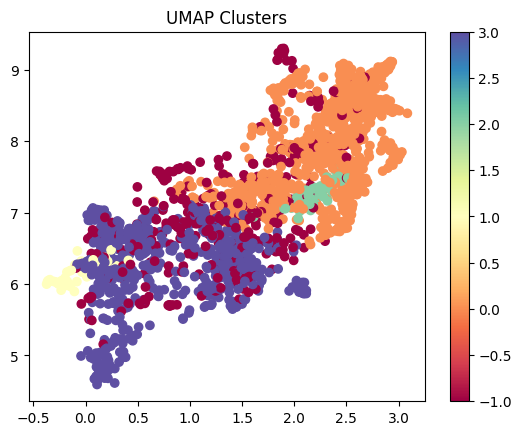

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='Spectral')
plt.colorbar()
plt.title("UMAP Clusters")
plt.show()


Based on the keywords associated with each cluster, here are the suggested names that characterize their main themes:

1. **Cluster 0: TikTok and General Health Content**  
   Focuses on TikTok’s role in disseminating health-related information, content quality, and platform usage for health communication.

2. **Cluster 1: TikTok's Global Reach and Chinese Influence**  
   Highlights TikTok’s international impact, its Chinese origins, and comparisons with its Chinese version, Douyin.

3. **Cluster 2: TikTok in Education and Learning**  
   Explores TikTok’s applications in educational contexts, including language learning, teaching strategies, and online education.

4. **Cluster 3: TikTok’s Sociopolitical and Digital Influence**  
   Captures TikTok’s role in social and political contexts, including its impact on platforms, political communication, and user engagement.

These names summarize the thematic focus of each cluster while maintaining clarity and relevance to the keywords provided. Let me know if you'd like further refinement!

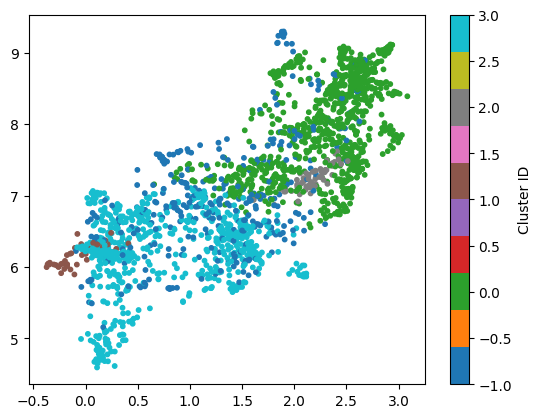

In [ ]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='tab10', s=10)
plt.colorbar(label='Cluster ID')


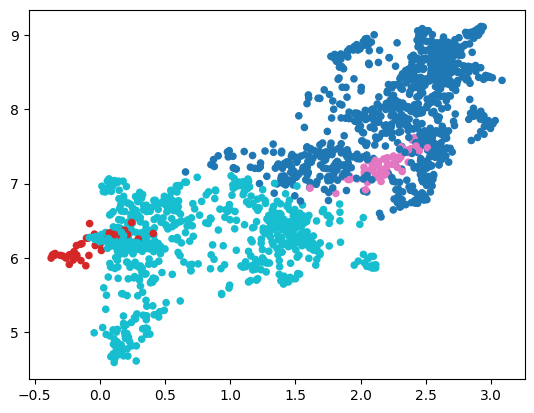

In [ ]:
valid_points = clusters != -1
plt.scatter(reduced_embeddings[valid_points, 0], reduced_embeddings[valid_points, 1], c=clusters[valid_points], cmap='tab10', s=20)
